**Question 2:** Analyze the data and make justifications on why the peak load use was the 
hour that it was.

In [131]:
# Import libraries

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os

**Step 1: Data Collection and Preprocessing**\
\
**a. Import Rhode Island data file and clean data types**
> I imported the Rhode Island electricity load data to a pandas dataframe and cleaned the time column to be separated into date and hour.\
Lastly, I dropped the time and zonal_name columns since they won't be useful for this analysis.

In [132]:
cd = os.getcwd()
file = cd[:-7] + 'Data/RI-2024-10.csv' # Change so this works in folder structure for another PC.
ri_load_df = pd.read_csv(file)
ri_load_df['time'] = pd.to_datetime(ri_load_df['time'])
ri_load_df['date'] = ri_load_df['time'].dt.date
ri_load_df['hour'] = ri_load_df['time'].dt.hour

ri_load_df = ri_load_df.drop(columns = ['time', 'zonal_name'])

display(ri_load_df.head(5))
ri_load_df.dtypes

,load,date,hour
0,609.207,2024-10-01,5
1,598.181,2024-10-01,6
2,578.324,2024-10-01,7
3,646.755,2024-10-01,8
4,768.010,2024-10-01,9


load    float64
date     object
hour      int32
dtype: object

**b. What hour has the highest load?**
> I want to find which date and hour had the highest load so I can collect weather data for the surrounding days.\
Normally we would have a data feed so I could analyze all hours in October 2024 but that will take too much time for this assignment.\
The peak load ocurred on **October 4 at hour ending 19 (7pm)**. I will collect data for the surrounding days and import into the notebook.

In [133]:
max_load_row = ri_load_df[ri_load_df['load'] == ri_load_df['load'].max()]
print(f"Max load in Rhode Island in October 2024 happened on {max_load_row['date'].iloc[0]} at hour {max_load_row['hour'].iloc[0]}")

Max load in Rhode Island in October 2024 happened on 2024-10-04 at hour 19


**c. Import Providence weather data**
> I chose to use weather data from Providence because it is the largest city in Rhode Island, so it should be one of largest contributors to the state's overall load.\
I removed some of the extra rows and added the hour column in Excel so I can merge to the demand data provided.\
Source: https://www.timeanddate.com/weather/usa/providence/historic?month=10&year=2024

In [ ]:
file = cd[:-7] + 'Data/providence_weather_data.csv'
weather_df = pd.read_csv(file, encoding='latin1')

weather_df['temperature'] = weather_df['temperature'].str.replace( "°C", "").astype(float)
weather_df['wind'] = weather_df['wind'].str.replace( "km/h", "", regex = False).replace("No wind", 0).astype(float)
weather_df['humidity'] = weather_df['humidity'].str.replace( "%", "").astype(float)
weather_df['barometer'] = weather_df['barometer'].str.replace( "kPa", "").astype(float)
weather_df['visibility'] = weather_df['visibility'].str.replace( "km", "").astype(float)
weather_df['hour'] = weather_df['hour'].astype('int32')
weather_df['date2'] = pd.to_datetime(weather_df['date']).dt.date

weather_df = weather_df.drop(columns = ['date'])
weather_df = weather_df.rename(columns={'date2': 'date'})

load_weather_df = ri_load_df.merge(weather_df, on = ['date', 'hour'], how = 'inner')
load_weather_df['weekday'] = pd.to_datetime(load_weather_df['date']).dt.day_name()

display(load_weather_df)


,load,date,hour,temperature,weather,wind,humidity,barometer,visibility,weekday
0,598.181,2024-10-01,6,13.0,Passing clouds.,9.0,100.00,101.94,11.0,Tuesday
1,578.324,2024-10-01,7,14.0,Fog.,11.0,100.00,101.94,3.0,Tuesday
2,646.755,2024-10-01,8,14.0,Fog.,13.0,100.00,101.97,2.0,Tuesday
3,768.010,2024-10-01,9,16.0,Partly sunny.,20.0,96.00,101.99,16.0,Tuesday
4,792.199,2024-10-01,10,18.0,Broken clouds.,17.0,81.00,102.01,16.0,Tuesday
...,...,...,...,...,...,...,...,...,...,...
282,867.112,2024-10-14,19,12.0,Passing clouds.,11.0,0.86,100.23,16.0,Monday
283,871.548,2024-10-14,20,12.0,Passing clouds.,17.0,0.69,100.35,16.0,Monday
284,897.331,2024-10-14,21,11.0,Passing clouds.,17.0,0.74,100.44,16.0,Monday
285,929.753,2024-10-14,22,10.0,Passing clouds.,22.0,0.71,100.61,16.0,Monday


**Step 2: Feature Engineering**\
\
**a. Find optimal base temperature to calculate CDD**
> I wanted to find the best base temperature to calcualate CDD. Below is a quick way of finding it.

In [135]:
# Check optimal base temp for CDD based on correlation.

base_temperatures = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0]

def calculate_cdd(temperature, base_temp):
    return max(0, temperature - base_temp)

correlation_results = {}

for base_temp in base_temperatures:
    load_weather_df[f'cdd_{base_temp}'] = load_weather_df['temperature'].apply(lambda x: calculate_cdd(x, base_temp))
    
    correlation = load_weather_df[f'cdd_{base_temp}'].corr(load_weather_df['load'])
    correlation_results[base_temp] = correlation

best_base_temp = max(correlation_results, key=correlation_results.get)
print(f"The best base temperature for cooling degree days is {best_base_temp}°C with a correlation of {correlation_results[best_base_temp]:.2f}")

The best base temperature for cooling degree days is 4.0°C with a correlation of 0.35


In [136]:
load_weather_df = load_weather_df[['date', 'weekday', 'hour', 'load', 'temperature', 'cdd_4.0', 'wind', 'humidity', 'barometer', 'visibility']]
display(load_weather_df.head())

,date,weekday,hour,load,temperature,cdd_4.0,wind,humidity,barometer,visibility
0,2024-10-01,Tuesday,6,598.181,13.0,9.0,9.0,100.0,101.94,11.0
1,2024-10-01,Tuesday,7,578.324,14.0,10.0,11.0,100.0,101.94,3.0
2,2024-10-01,Tuesday,8,646.755,14.0,10.0,13.0,100.0,101.97,2.0
3,2024-10-01,Tuesday,9,768.010,16.0,12.0,20.0,96.0,101.99,16.0
4,2024-10-01,Tuesday,10,792.199,18.0,14.0,17.0,81.0,102.01,16.0


**Step 3: Exploratory Data Analysis**
> The purpose of this step is to visualize the data so I can explain why peak demand was highest on October 4th at 7pm using the collected weather data.

**a. Correlation Matrix**
> This matrix is showing that no one individual variable is significantly affecting hourly load for the dates. There seems to be many variables that have a slight affect on the hourly load; cooling degree days has the most significant correlation followed by humidity.

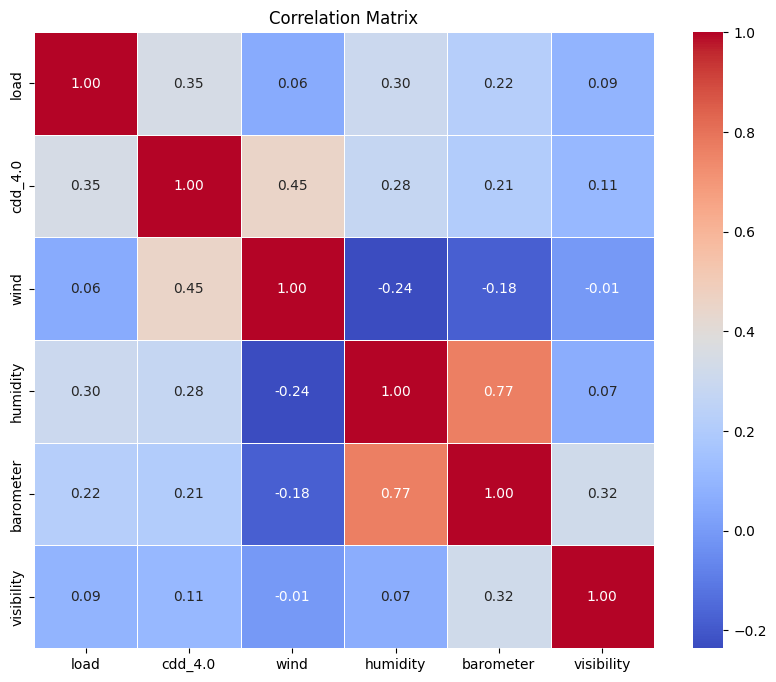

In [137]:
correlation_data = load_weather_df[['load', 'cdd_4.0', 'wind', 'humidity', 'barometer', 'visibility']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix")
plt.show()

**b. Testing thermal inertia**
> None the features we have seem to be a significant inicator to explain why hour load peaked on October 4th, 7pm. So I want to test a lag variable that averages the last 8 hours of cooling degree days. My theory is based on the fact daily demand seems to peak around 7pm every day when people are likely ending their work day.

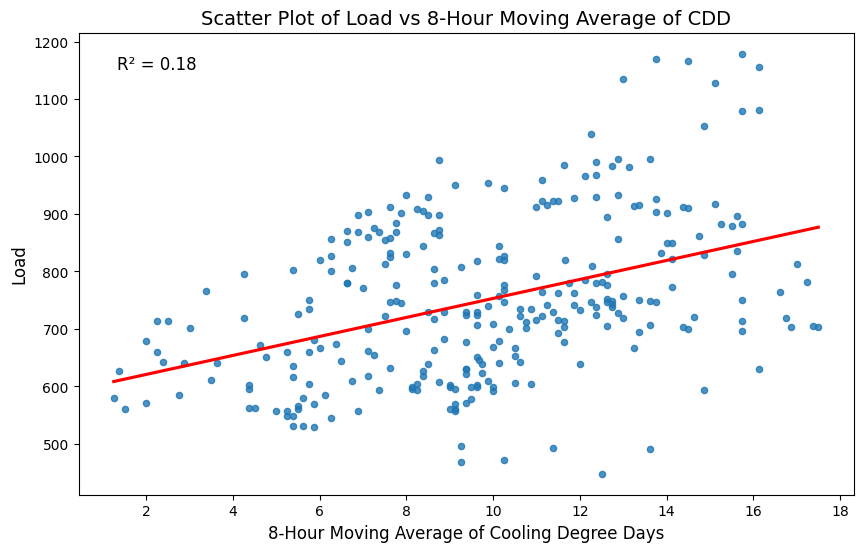

In [151]:
from scipy import stats

load_weather_df['cdd_8hr_avg'] = load_weather_df['cdd_4.0'].rolling(window = 8, min_periods = 1).mean()

plt.figure(figsize=(10, 6))

# Create the scatter plot with a trendline
sns.regplot(x='cdd_8hr_avg', y='load', data = load_weather_df, scatter_kws={'s': 20}, line_kws={'color': 'red'}, ci=None)

# Calculate the R-squared value
slope, intercept, r_value, p_value, std_err = stats.linregress(load_weather_df['cdd_8hr_avg'], load_weather_df['load'])
r_squared = r_value**2

# Add a title and labels
plt.title('Scatter Plot of Load vs 8-Hour Moving Average of CDD', fontsize=14)
plt.xlabel('8-Hour Moving Average of Cooling Degree Days', fontsize=12)
plt.ylabel('Load', fontsize=12)

# Display the R-squared value on the plot
plt.text(0.05, 0.95, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Show the plot
plt.show()

In [51]:
weather_df.dtypes

date            object
hour             int32
time            object
temperature    float64
weather         object
wind           float64
humidity       float64
barometer      float64
visibility     float64
date2           object
dtype: object

In [ ]:

ri_load_df.dtypes

load    float64
date     object
hour      int32
dtype: object